<a href="https://colab.research.google.com/github/BhojRajBist/BhojRajBist/blob/main/DummyNCRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

root_dir = "20240621"

# Create the directory if it does not exist
if not os.path.exists(root_dir):
    os.makedirs(root_dir)
    print(f"Directory {root_dir} created.")
else:
    print(f"Directory {root_dir} already exists.")

Directory 20240621 created.


In [2]:
#Mention Root Directory
root_dir = "20240621"

In [3]:
# Define the latitude and longitude bounds for Nepal (For specific region change here)
# NCUMGLB12.5 only available for lat [26, 31] and lon [79, 89]

lat_bounds = [26, 31]
lon_bounds = [79, 89]

# Set the interval time in milliseconds
interval_time = 1000  # 1 second

In [4]:
!pip install netCDF4 xarray rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00


In [5]:
pip install cartopy xarray netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.7 MB/s eta 0:00:00


In [6]:
# Import necessary packages
import os
from datetime import datetime
import ftplib
import subprocess
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import HTML
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from pyproj import CRS
from osgeo import gdal
import shutil
import re

In [11]:
# File Name and Path being generated
file_name = f"APCP_3hourly_ncum_reg_{root_dir}_00Z.nc"
file_name1 = f"ncumglb_prg_26-31N_79-89E_0.125x0.125_{root_dir}_00Z.nc"

# Construct the file path
file_path = os.path.join(root_dir, file_name)
file_path1 = os.path.join(root_dir, file_name1)

print(f"File path: {file_path}")
print(f"File path: {file_path1}")

File path: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
File path: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc


In [16]:
import os
import xarray as xr
import numpy as np
from rasterio.transform import from_origin
import rasterio
from datetime import datetime
from pyproj import CRS

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240621"

# Create the root directory if it does not exist
os.makedirs(root_dir, exist_ok=True)

# Define file names based on root directory
file_name = f"APCP_3hourly_ncum_reg_{root_dir}_00Z.nc"
file_name1 = f"ncumglb_prg_26-31N_79-89E_0.125x0.125_{root_dir}_00Z.nc"

# Construct the file paths
file_path = os.path.join(root_dir, file_name)
file_path1 = os.path.join(root_dir, file_name1)

# Function to create a dummy NetCDF file
def create_dummy_netcdf(file_path, lat_bounds, lon_bounds):
    lat = np.linspace(lat_bounds[0], lat_bounds[1], 100)
    lon = np.linspace(lon_bounds[0], lon_bounds[1], 100)
    time = pd.date_range("2024-06-21", periods=8, freq='3H')

    data = np.random.rand(len(time), len(lat), len(lon))

    ds = xr.Dataset(
        {
            "param8.1.0": (["time", "lat", "lon"], data)
        },
        coords={
            "lat": lat,
            "lon": lon,
            "time": time,
        }
    )

    ds.to_netcdf(file_path)
    print(f"Dummy NetCDF file created: {file_path}")

# Create the dummy NetCDF files
create_dummy_netcdf(file_path, lat_bounds, lon_bounds)
create_dummy_netcdf(file_path1, lat_bounds, lon_bounds)

# Function to check if a file exists
def check_file_exists(file_path):
    if os.path.isfile(file_path):
        print(f"File exists: {file_path}")
        return True
    else:
        print(f"File not found: {file_path}")
        return False

# Check if the files exist
file_exists_1 = check_file_exists(file_path)
file_exists_2 = check_file_exists(file_path1)

# Function to download and clip NetCDF data to TIFF
def clip_netcdf_to_tiff(file_path, resolution):
    if not check_file_exists(file_path):
        return []

    # Extract the forecast origin string from the file path
    filename = os.path.basename(file_path)

    # Assuming the forecast origin date is in the filename in the format YYYYMMDD
    forecast_origin_str = filename.split('_')[-2]
    forecast_origin = datetime.strptime(forecast_origin_str, "%Y%m%d")

    # Open the NetCDF dataset
    dataset = xr.open_dataset(file_path)

    # Subset the dataset to the specified region
    subset_dataset = dataset.sel(lat=slice(lat_bounds[0], lat_bounds[1]), lon=slice(lon_bounds[0], lon_bounds[1]))

    # Create the output directory if it doesn't exist
    output_dir_tiff = os.path.join(root_dir, "TIFF_Files_" + resolution)
    os.makedirs(output_dir_tiff, exist_ok=True)

    # List to store file paths
    tiff_file_paths = []

    # Define the CRS for the output raster
    output_crs = CRS.from_epsg(4326)  # WGS 1984

    # Loop through each time step in the dataset
    for i, time_step in enumerate(subset_dataset['time']):
        # Get the data array for the current time step
        data_array = subset_dataset['param8.1.0'].isel(time=i).values

        # Get the time string for the current time step
        time_string = str(time_step.values)[:-10]  # Exclude milliseconds
        time_format = "%Y-%m-%dT%H:%M:%S"
        time_obj = datetime.strptime(time_string, time_format)

        # Calculate the timestep in hours
        timestep_hours = int((time_obj - forecast_origin).total_seconds() / 3600)
        timestep_str = f"{timestep_hours:03d}"  # Format as three digits

        # Calculate the forecast hour index (incrementing integer starting from 00)
        forecast_hour_index = i + 1
        forecast_hour_index_str = f"{forecast_hour_index:02d}"  # Format as two digits

        # Set the output file name
        output_name = f'NCMRWF_Nepal_{time_obj.strftime("%Y%m%d%H")}F{forecast_hour_index_str}O{forecast_origin_str}00H{timestep_str}R{resolution}.tif'

        # Get the GeoTransform
        transform = from_origin(lon_bounds[0], lat_bounds[0], subset_dataset.lon.values[1] - subset_dataset.lon.values[0], subset_dataset.lat.values[0] - subset_dataset.lat.values[1])

        # Set the output file path
        output_file = os.path.join(output_dir_tiff, output_name)

        # Write the data array to the output TIFF file
        with rasterio.open(output_file, 'w', driver='GTiff', count=1, dtype='float32', crs=output_crs, transform=transform, width=data_array.shape[1], height=data_array.shape[0]) as dst:
            dst.write(data_array, 1)

        # Append the output file path to the list
        tiff_file_paths.append(output_file)

    print("TIFF files generated and saved successfully.")

    # Return the list of file paths
    return tiff_file_paths

# Generate TIFF files if the files exist
if file_exists_1:
    tiff_files = clip_netcdf_to_tiff(file_path, '4KM')
    print("TIFF files generated for APCP 4 km:", tiff_files)

if file_exists_2:
    tiff_files1 = clip_netcdf_to_tiff(file_path1, '12.5KM')
    print("TIFF files generated for NCUMGLB 12.5 km:", tiff_files1)




Dummy NetCDF file created: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
Dummy NetCDF file created: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
File exists: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
TIFF files generated and saved successfully.
TIFF files generated for APCP 4 km: ['20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062100F01O2024062100H000R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062103F02O2024062100H003R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062106F03O2024062100H006R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062109F04O2024062100H009R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062112F05O2024062100H012R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062115F06O2024062100H015R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062118F07O2024062100H018R4KM.tif', '20240621/TIFF_File

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Frames saved successfully.
Animation saved as 20240621/precipitation_animation_20240621.gif.


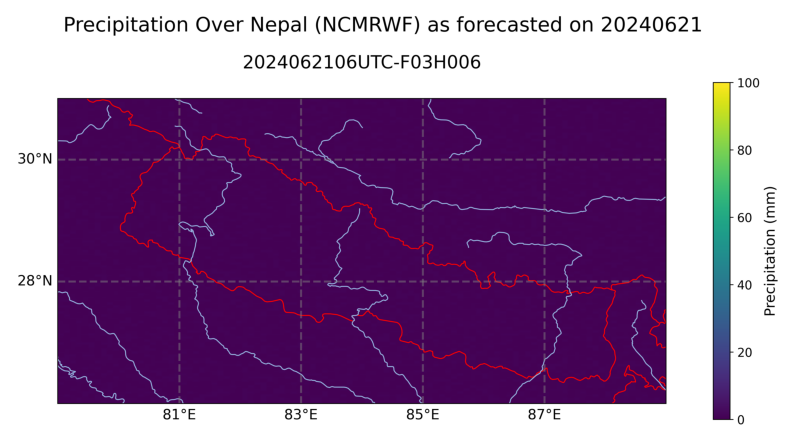

In [18]:
# Directory to save frames
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Function to plot precipitation data over Nepal from TIFF files
def animate_precipitation_data_tiff(directory):
    # Get a list of all TIFF files in the directory
    tiff_files = [f for f in os.listdir(directory) if f.endswith('.tif')]

    # Plot each TIFF file
    for i, tiff_file in enumerate(tiff_files):
        file_path = os.path.join(directory, tiff_file)
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1, edgecolor='red')
            ax.add_feature(cfeature.RIVERS)

            # Define the extent explicitly using bounds
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], transform=ccrs.PlateCarree(), vmin=0, vmax=100)

            # Set the title with the file name
            filename = f'{tiff_file}'

            # Split the filename by underscores to get parts
            parts = filename.split('_')

            # Extract the timestamp part and remove any additional characters
            timestamp = parts[2].split('F')[0]  # 'F' is the separator

            # Extract the forecast index part and remove any additional characters
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # 'F' is the separator

            # Extract the forecast hours part and remove any additional characters
            forecastHrsPart = parts[2].split('H')[1]  # 'H' is the separator
            forecastHrs = forecastHrsPart.split('R')[0]  # 'H' is the separator

            # Use the extracted timestamp and forecast hours as tile
            title = timestamp + 'UTC-F' + forecastIndex + 'H' +forecastHrs

            ax.set_title(title, fontsize=18, pad=30)

            # Set up gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False  # Hide top labels
            gl.right_labels = False  # Hide right labels
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

            # Extract longitude and latitude values for gridlines
            lon_ticks = np.arange(lon_bounds[0], lon_bounds[1] + 1, 2)
            lat_ticks = np.arange(lat_bounds[0], lat_bounds[1] + 1, 2)

            # Set gridline locations
            gl.xlocator = plt.FixedLocator(lon_ticks)
            gl.ylocator = plt.FixedLocator(lat_ticks)

            # Set a common title for all subplots
            fig.suptitle(f"Precipitation Over Nepal (NCMRWF) as forecasted on {root_dir}", fontsize=20, y=0.90)

            # Add a single colorbar for the plot and create a color bar with range 0 to 100
            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.07, fraction=0.025, norm=norm, location='right')
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400)
            plt.close(fig)

    print("Frames saved successfully.")

     # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=interval_time)

    # Display the animation
    return HTML(ani.to_html5_video())

TIFF_120Hrs = os.path.join(root_dir, "TIFF_Files_4KM")
# Call the function to plot precipitation data
animate_precipitation_data_tiff(TIFF_120Hrs)


In [26]:
!apt-get install -y gdal-bin



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.6.4+dfsg-1~jammy0 [1,027 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.6.4+dfsg-1~jammy0 [561 kB]
Fetched 5,055 kB in 1s (3,687 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 121925 files and direc

In [27]:
import os
os.environ['PATH'] += ":/usr/local/lib/python3.10/dist-packages/osgeo"

# Get all TIFF files in the directory
tiff_files = [os.path.join(TIFF_120Hrs, f) for f in os.listdir(TIFF_120Hrs) if f.endswith('.tif')]

# Print the list of TIFF files
print(f"TIFF files generated: {tiff_files}")

# Function to convert TIFF to COG TIFF
def tiff_to_cogtiff(tiff_file_paths):
    # Create the output directory if it doesn't exist
    output_dir_cog = os.path.join(root_dir, "COG_Files")
    os.makedirs(output_dir_cog, exist_ok=True)

    # List to store COG file paths
    cog_file_paths = []

    if not tiff_file_paths:
        print("No TIFF files provided for conversion.")
        return cog_file_paths

    for tiff_file in tiff_file_paths:
        # Set the COG output file path
        cog_output_file = os.path.join(output_dir_cog, os.path.basename(tiff_file).replace('.tif', 'C.tif'))

        # Print debug information
        print(f"Converting {tiff_file} to {cog_output_file}")

        # Convert the TIFF to Cloud Optimized GeoTIFF
        try:
            result = subprocess.run(
                ['gdal_translate', tiff_file, cog_output_file, '-co', 'TILED=YES', '-co', 'COPY_SRC_OVERVIEWS=YES', '-co', 'COMPRESS=DEFLATE'],
                check=True,
                capture_output=True,
                text=True
            )
            print(f"GDAL output: {result.stdout}")
            print(f"GDAL errors: {result.stderr}")

            # Append the COG file path to the list
            cog_file_paths.append(cog_output_file)
        except subprocess.CalledProcessError as e:
            print(f"Error converting {tiff_file}: {e.stderr}")

    print("COG TIFF files generated and saved successfully.")

    return cog_file_paths

# Step 3: Convert the TIFF files to COG TIFF
cog_tiff_files = tiff_to_cogtiff(tiff_files)

# Print TIFF files to verify
print("Cloud Optimized GeoTIFFs files generated:", cog_tiff_files)


TIFF files generated: ['20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062115F06O2024062100H015R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062109F04O2024062100H009R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062103F02O2024062100H003R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062112F05O2024062100H012R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062118F07O2024062100H018R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062121F08O2024062100H021R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062100F01O2024062100H000R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062106F03O2024062100H006R4KM.tif']
Converting 20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062115F06O2024062100H015R4KM.tif to 20240621/COG_Files/NCMRWF_Nepal_2024062115F06O2024062100H015R4KMC.tif
GDAL output: Input file size is 100, 100
0...10...20...30...40...50...60...70...80...90...100 - done.

GDAL errors: 
Converting 20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062109F04O2024062100H009R4KM.tif t